In [1]:
library(tidyverse)
library(magrittr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
snp2gene <- read_tsv('/Users/hclimente/projects/genewa/data/snp2gene/snp2hgnc.tsv', 
                     col_types = 'cc')
map <- read_tsv('/Users/hclimente/data/genesis/genesis.final.map',
                      col_names = F, col_types = 'icii') %>%
    set_colnames(c('chr', 'snp', 'cm', 'pos'))
hl_snps <- read_tsv('../results/gwas/brca_C=50_SELECT=50_M=3_B=5.txt', 
                 col_names = F, col_types = 'c') %>%
    set_colnames('snp') %>%
    mutate(rank = seq(1, n()) ) %>%
    left_join(snp2gene, by = 'snp') %>%
    left_join(map, by = 'snp')

In [3]:
hl_snps

snp,rank,symbol,chr,cm,pos
rs1325287,1,ST6GALNAC3,1,0,76822376
rs12134245,2,NA,1,0,92021464
rs219176,3,LTBP1,2,0,33230086
rs992351,4,NA,2,0,78001566
rs10932860,5,LINC01876,2,0,156935758
rs10929320,6,TRPM8,2,0,234868385
rs2317907,7,IQCA1,2,0,237392284
rs155863,8,NA,3,0,1449151
rs747606,9,NA,4,0,30669328
rs1865185,10,ARAP2,4,0,35979627


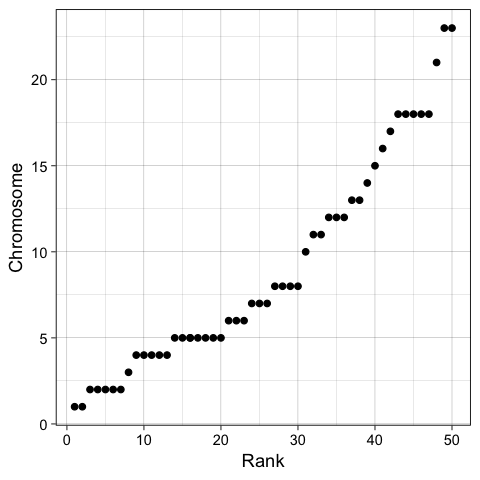

In [4]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(hl_snps, aes(x = rank, y = chr)) +
    geom_point() +
    labs(x = 'Rank', y = 'Chromosome') +
    theme_linedraw()

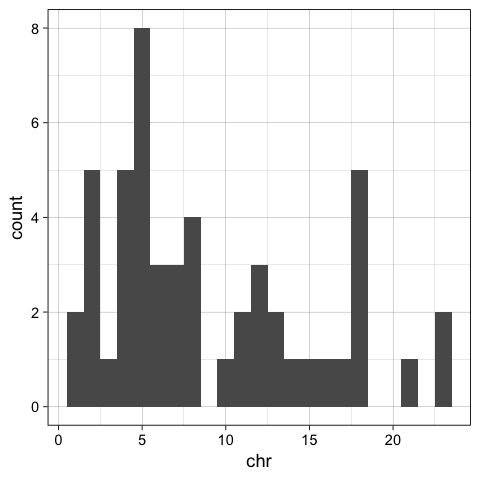

In [5]:
ggplot(hl_snps, aes(chr)) + 
    geom_histogram(bins = 23) +
    theme_linedraw()

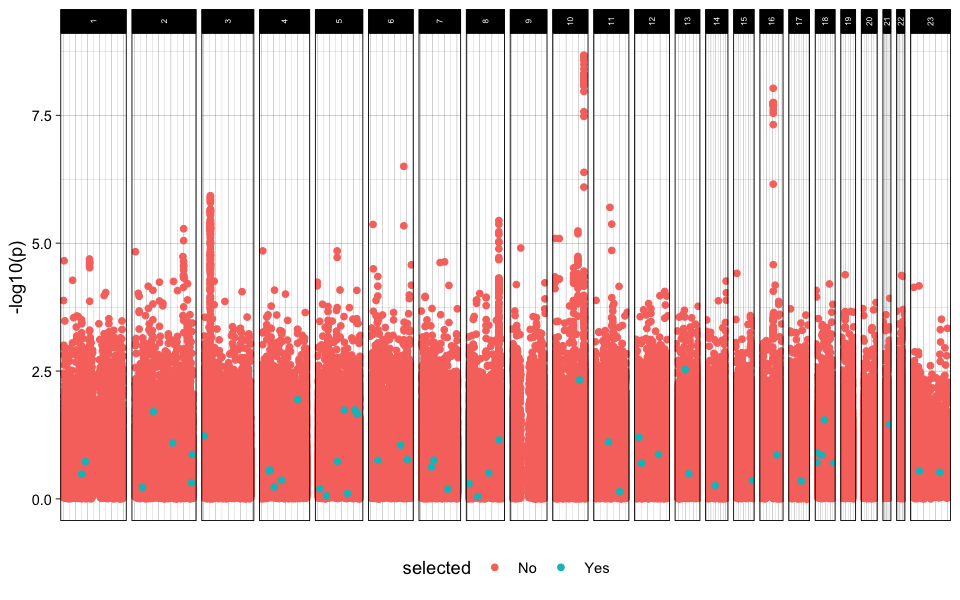

In [6]:
gwas <- read_tsv('../../genewa/results/genesis/cones.evo.chi2.consistency.additive.gs.6082272.tsv',
                col_types = 'ciiiccdlc') %>%
    mutate(p = pchisq(c, df = 1, lower.tail = FALSE),
           selected = ifelse(snp %in% hl_snps$snp, 'Yes', 'No')) %>%
    arrange(selected)

options(repr.plot.width=8, repr.plot.height=5)
ggplot(gwas, aes(x = pos, y = -log10(p), color = selected )) +
    geom_point() +
    facet_grid(. ~ chr, scales = 'free', space = "free_x") +
    theme_linedraw() +
    theme(legend.position = 'bottom',
          axis.text.x = element_blank(),
          axis.title.x=element_blank(),
          axis.ticks.x=element_blank(),
          panel.spacing.x = unit(0.2, "lines"),
          strip.text.x = element_text(size = 5, angle = 90)) +
    labs(x = 'Genomic position')